In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import importlib
warnings.filterwarnings('ignore')

In [3]:
from analysis.data.dataframe_creation import pipeline
sd = "2018-01-01"
ed = "2024-01-01"
dataset = pipeline(sd, ed)

[*********************100%***********************]  1 of 1 completed
[                       0%                       ]

Total number of tickers 502


[*********************100%***********************]  502 of 502 completed

5 Failed downloads:
['SOLV', 'SW', 'GEV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1514782800, endDate = 1704085200")')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01)')



Null values: False
NaN values: False

Creating features
The dataset has 485 assets
The dataset has 16 predictors:
Ticker
Yavg_return
Yavg_volatility
beta
mkt_corr
Davg_span
Davg_volume
D_eSkewness
D_eVaR
D_eCVaR
D_eCurtosis
Sharpe_ratio
totalEsg
environmentScore
socialScore
governanceScore
industry


Dataset creation finished



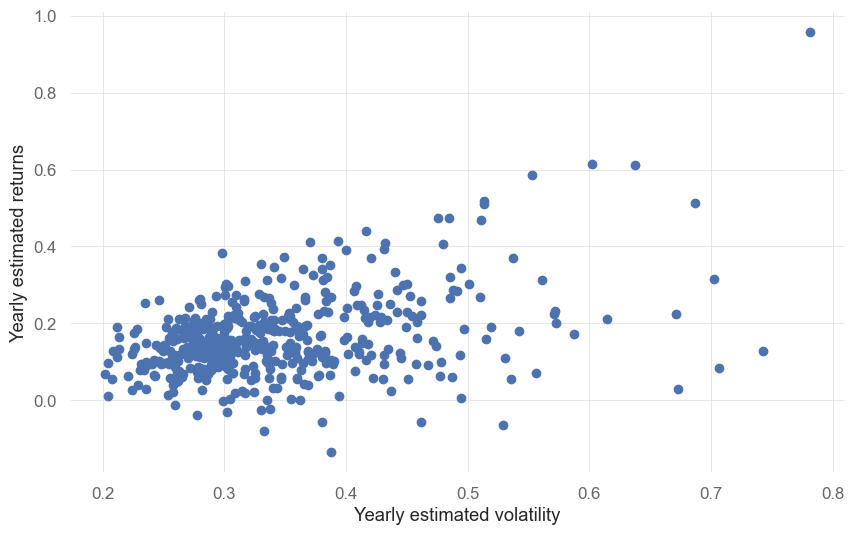

In [4]:
plt.scatter(dataset["Yavg_volatility"], dataset["Yavg_return"])
plt.xlabel("Yearly estimated volatility")
plt.ylabel("Yearly estimated returns")
plt.show()

In [5]:
outliers = outliers = dataset[
    (dataset["Yavg_return"] > 0.8)]["Ticker"].unique()
final_dataframe = dataset[~dataset["Ticker"].isin(outliers)]
final_dataframe.head()

,Ticker,Yavg_return,Yavg_volatility,beta,mkt_corr,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,Sharpe_ratio,totalEsg,environmentScore,socialScore,governanceScore,industry
0,A,0.170255,0.290318,1.006775,0.707046,2.268208,1.961764e+06,-0.134997,-0.000283,-0.000401,4.334463,0.517552,11.36,1.19,6.23,3.93,Life Sciences Tools and Services
1,AAPL,0.309906,0.316770,1.238241,0.796984,2.378506,1.073273e+08,-0.036495,-0.000292,-0.000426,4.924360,0.915194,16.79,0.55,7.52,8.72,Technology
2,ABBV,0.159055,0.273195,0.657252,0.490510,2.003774,7.196053e+06,-0.845041,-0.000286,-0.000483,13.941115,0.508994,26.10,1.78,15.70,8.62,Biotechnology
3,ABT,0.155088,0.257788,0.853279,0.674864,1.733056,5.701730e+06,0.048213,-0.000290,-0.000434,6.096852,0.524026,22.21,1.81,13.84,6.56,Health Care
4,ACGL,0.204344,0.314158,0.979198,0.635494,0.905297,1.859299e+06,-0.321692,-0.000771,-0.001249,11.651915,0.586789,20.27,1.57,9.92,8.78,Insurance


In [20]:
stock_data_clustering = final_dataframe[["Yavg_return",	"Yavg_volatility"]]

stock_data_clustering.info()

<class 'pandas.core.frame.DataFrame'>
Index: 484 entries, 0 to 484
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Yavg_return      484 non-null    float64
 1   Yavg_volatility  484 non-null    float64
dtypes: float64(2)
memory usage: 11.3 KB


In [21]:
from sklearn.preprocessing import MinMaxScaler
for attr in stock_data_clustering.columns:
    scaler = MinMaxScaler()
    stock_data_clustering[attr] = scaler.fit_transform(stock_data_clustering[attr].values.reshape(-1, 1)).flatten()

In [23]:
from analysis.clustering.kmedoids_clustering import run_kmedoids
clusters = range(2, 20)
runs = 60
meanDistortions, sil_score, inertias = run_kmedoids(clusters, stock_data_clustering, runs)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [11]:
from analysis.data.plotting import plot_kmeans
plot_kmeans(runs, clusters, meanDistortions, sil_score, inertias)

NameError: name 'runs' is not defined

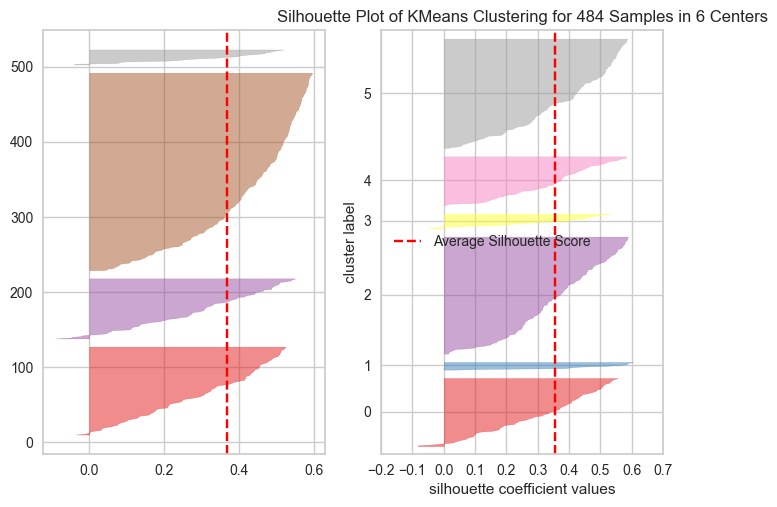

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 484 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [18]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
plt.subplot(1,2,1)
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(stock_data_clustering)
plt.subplot(1,2,2)
visualizer = SilhouetteVisualizer(KMeans(6, random_state=1))

visualizer.fit(stock_data_clustering)

visualizer.show()

In [17]:
N_SECTORS = 6

kmeans = KMeans(n_clusters=N_SECTORS, random_state=0)
kmeans.fit(stock_data_clustering)
final_dataframe["Sector"] = kmeans.labels_
final_dataframe.head()

,Ticker,Yavg_return,Yavg_volatility,beta,mkt_corr,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,Sharpe_ratio,totalEsg,environmentScore,socialScore,governanceScore,industry,Sector
0,A,0.170254,0.290317,1.006775,0.707046,2.268208,1.961764e+06,-0.134997,-0.000283,-0.000401,4.334486,0.517552,11.36,1.19,6.23,3.93,Life Sciences Tools and Services,5
1,AAPL,0.309906,0.316770,1.238242,0.796984,2.378506,1.073273e+08,-0.036494,-0.000292,-0.000426,4.924366,0.915194,16.79,0.55,7.52,8.72,Technology,5
2,ABBV,0.159055,0.273195,0.657252,0.490510,2.003774,7.196053e+06,-0.845043,-0.000286,-0.000483,13.941136,0.508994,26.10,1.78,15.70,8.62,Biotechnology,5
3,ABT,0.155088,0.257788,0.853279,0.674864,1.733056,5.701730e+06,0.048214,-0.000290,-0.000434,6.096861,0.524026,22.21,1.81,13.84,6.56,Health Care,0
4,ACGL,0.204344,0.314158,0.979198,0.635494,0.905297,1.859299e+06,-0.321692,-0.000771,-0.001249,11.651915,0.586789,20.27,1.57,9.92,8.78,Insurance,5


In [19]:
cluster_profile = final_dataframe.groupby("Sector").mean(numeric_only=True)

# Add counts for the number of stocks in each cluster
cluster_profile["Count"] = final_dataframe.groupby("Sector")["Ticker"].count().values
cluster_profile["Sharpe_ratio"] = (cluster_profile["Yavg_return"]-0.02)/cluster_profile["Yavg_volatility"]

max_cols = ["beta", "D_eSkewness", "Yavg_return", "Sharpe_ratio", "Davg_volume"]
min_cols = ["beta", "Davg_span", "D_eCurtosis", "Yavg_volatility", "D_eVaR", "D_eCVaR", 
            "totalEsg", "environmentScore", "socialScore", "governanceScore"]

# Custom function for styling
def highlight_extremes(val, col_name):
    max_color = "background-color: green"
    min_color = "background-color: blue"
    
    if col_name in max_cols and val == cluster_profile[col_name].max():
        return max_color
    elif col_name in min_cols and val == cluster_profile[col_name].min():
        return min_color
    return ""

cluster_profile.style.apply(lambda x: [highlight_extremes(v, x.name) for v in x], axis=0)
# cluster_profile.style.highlight_max(color="green", axis=0, subset=["beta", "D_eSkewness",	"Yavg_return", "Sharpe_ratio", "Davg_volume"])
# cluster_profile.style.highlight_min(color="green", axis=0, subset=["beta", "Davg_span", "D_eCurtosis",	"Yavg_volatility", "D_eVaR", "D_eCVaR", "totalEsg",	"environmentScore",	"socialScore",	"governanceScore"])

,Yavg_return,Yavg_volatility,beta,mkt_corr,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,Sharpe_ratio,totalEsg,environmentScore,socialScore,governanceScore,Count
Sector,,,,,,,,,,,,,,,,
0,0.097064,0.268763,0.751711,0.567194,2.110513,3918787.146146,-0.227080,-0.000431,-0.000694,12.312201,0.286736,21.338621,6.782000,9.356345,5.200483,146
1,0.287054,0.415182,1.269563,0.627160,4.454571,4594255.244843,0.014132,-0.000538,-0.000836,10.902534,0.643221,20.555937,6.135781,8.812500,5.607812,64
2,0.134428,0.560548,1.402923,0.513663,2.749279,8059284.911332,0.103875,-0.001404,-0.002408,18.868035,0.204136,24.754000,8.513200,10.131200,6.109600,25
3,0.088254,0.376797,1.123657,0.608524,1.933167,6268852.964251,-0.093808,-0.000947,-0.001492,12.634981,0.181141,20.018681,5.247253,8.779451,5.991978,92
4,0.487315,0.546155,1.417997,0.542997,3.425067,60960984.857522,0.169388,-0.001781,-0.002804,11.708429,0.855646,21.005000,6.059091,9.539091,5.456364,12
5,0.196327,0.308456,0.984637,0.651841,4.968445,4505671.510007,-0.041228,-0.000383,-0.000601,10.828116,0.571645,18.927902,4.535385,8.791608,5.600350,145


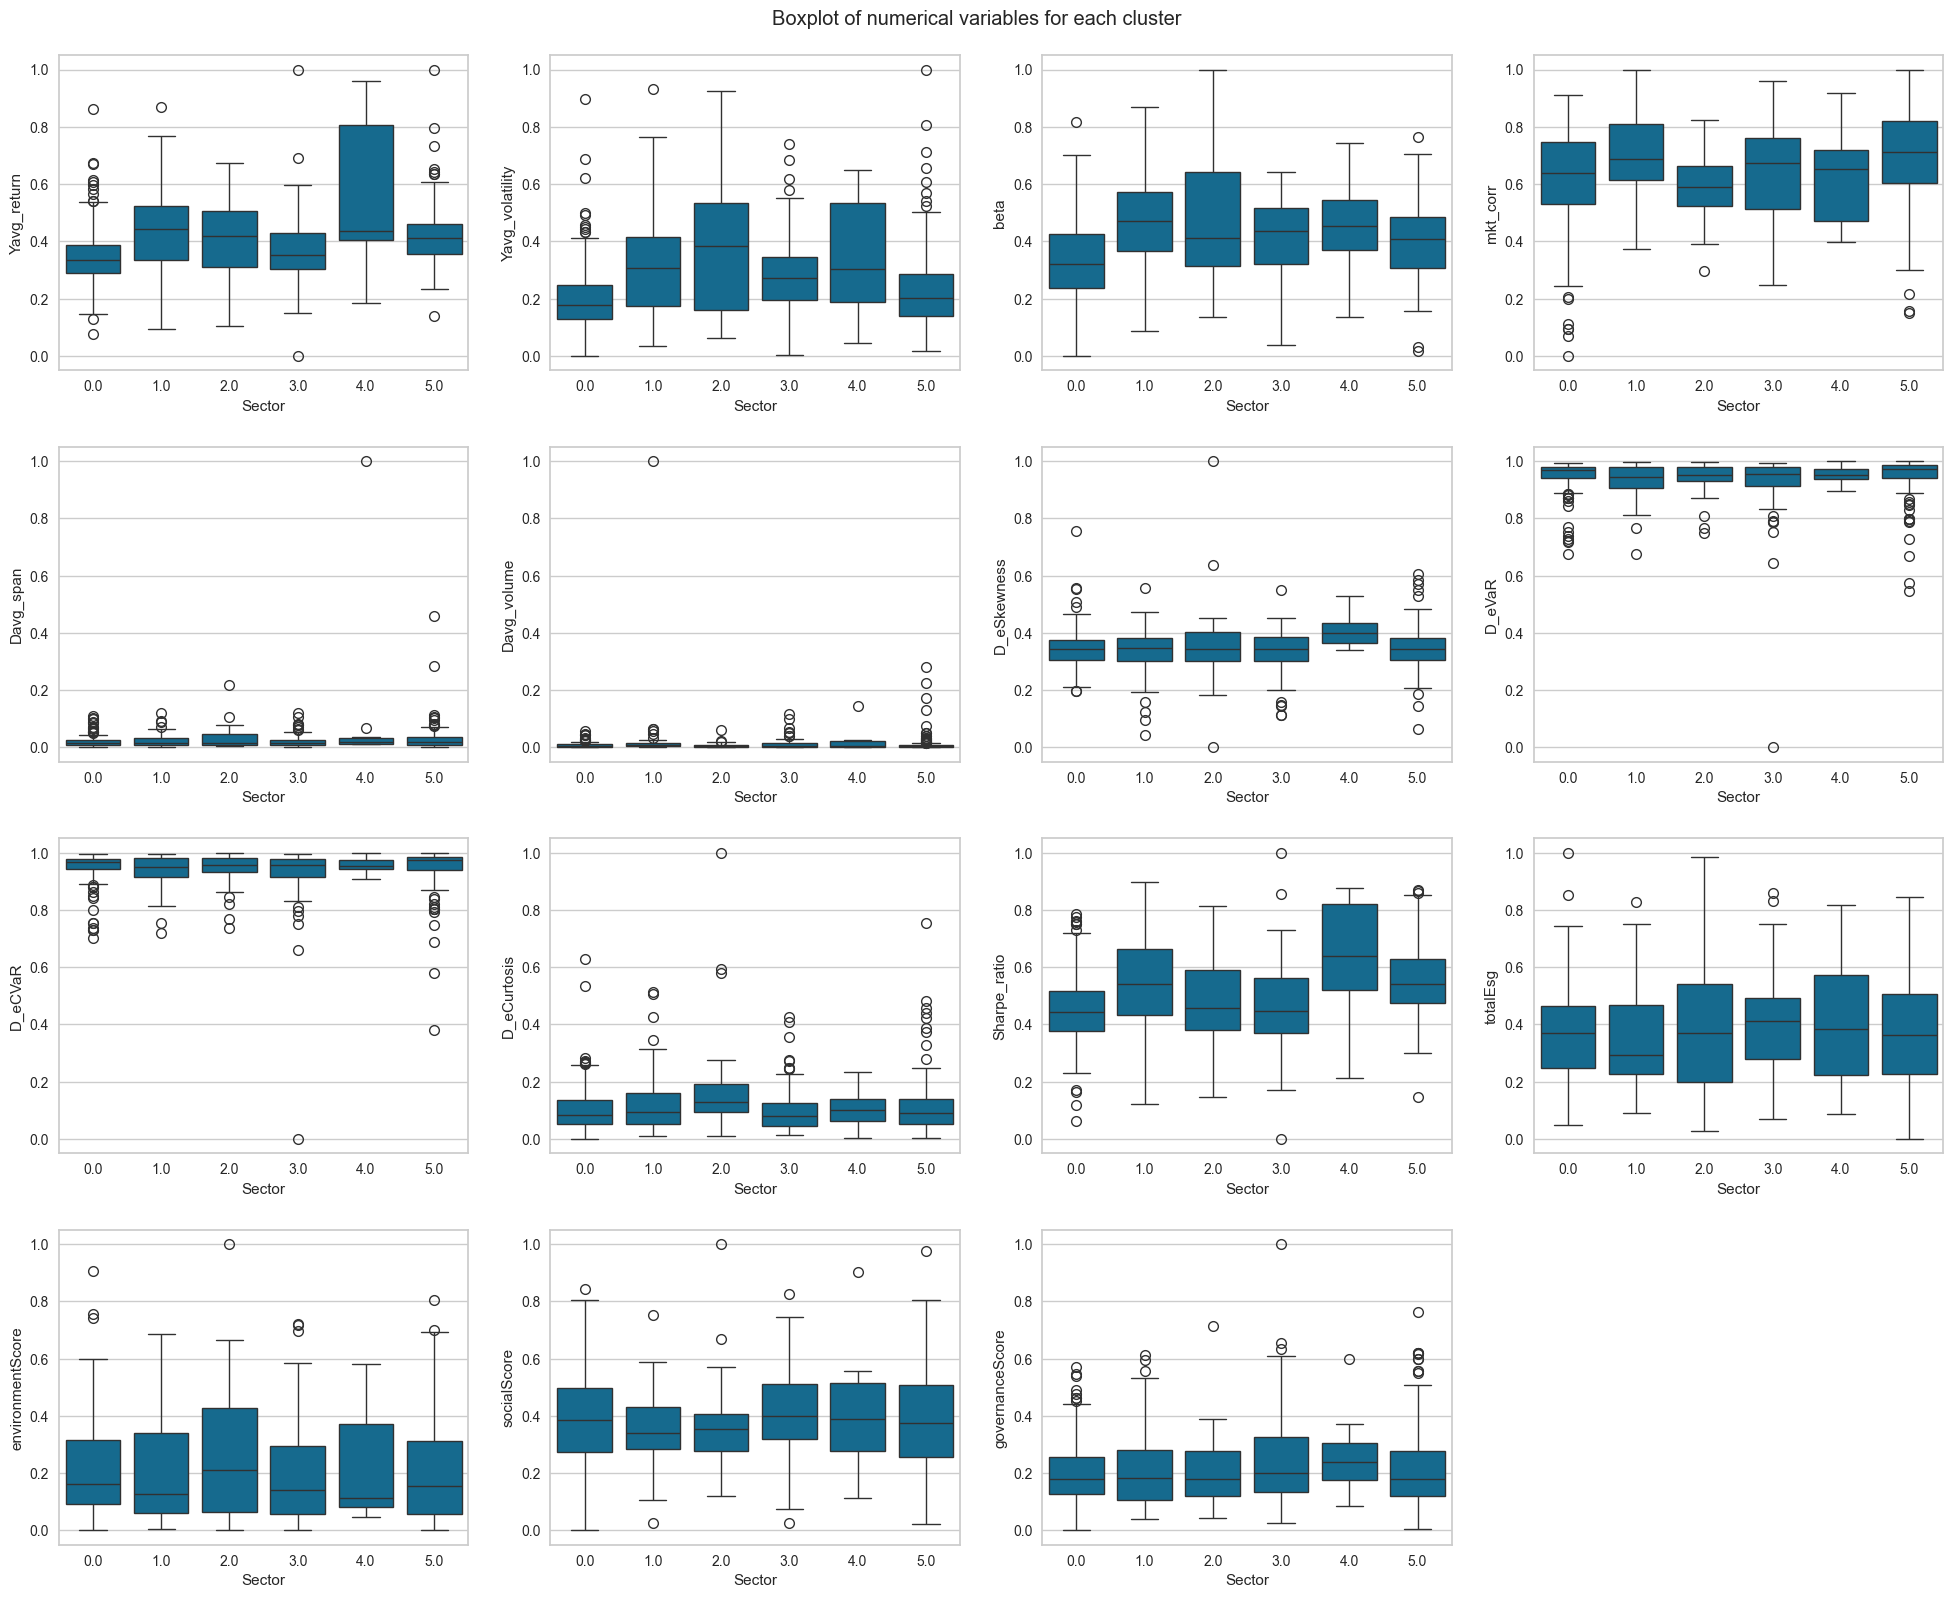

In [24]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaled_data = pd.DataFrame()
for attr in final_dataframe.select_dtypes(include=["float64", "int64"]).columns:
    scaler = MinMaxScaler()
    scaled_data[attr] = scaler.fit_transform(final_dataframe[attr].values.reshape(-1, 1)).flatten()
scaled_data["Sector"] = final_dataframe["Sector"]
plt.figure(figsize=(20, 20))
import seaborn as sns
plt.suptitle("Boxplot of numerical variables for each cluster")
i = 1
for i, variable in enumerate(final_dataframe):
  if variable not in ["Ticker", "industry", "Sector"]:
    plt.subplot(5, 4, i)
    sns.boxplot(data=scaled_data, x="Sector", y=variable)
    i += 1

plt.tight_layout(pad=2.0)

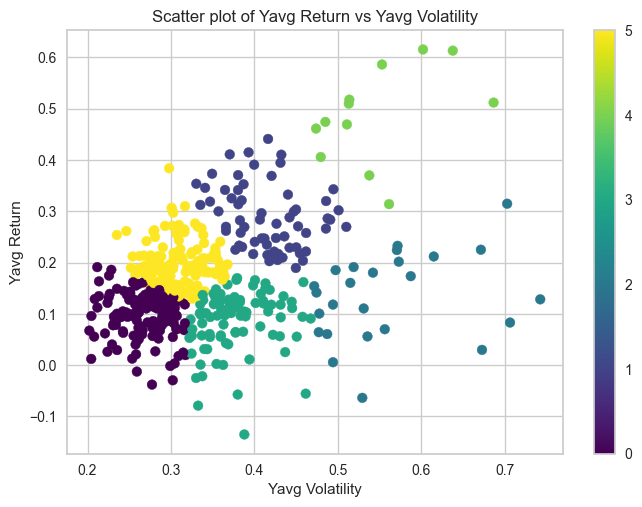

In [25]:
plt.scatter(
    final_dataframe["Yavg_volatility"], 
    final_dataframe["Yavg_return"], 
    c=final_dataframe["Sector"],  # Use c for color mapping
    cmap='viridis',  # Optional: Choose a colormap
    
)

# Add labels and title
plt.xlabel("Yavg Volatility")
plt.ylabel("Yavg Return")
plt.title("Scatter plot of Yavg Return vs Yavg Volatility")
plt.colorbar()
# Show the plot
plt.show()

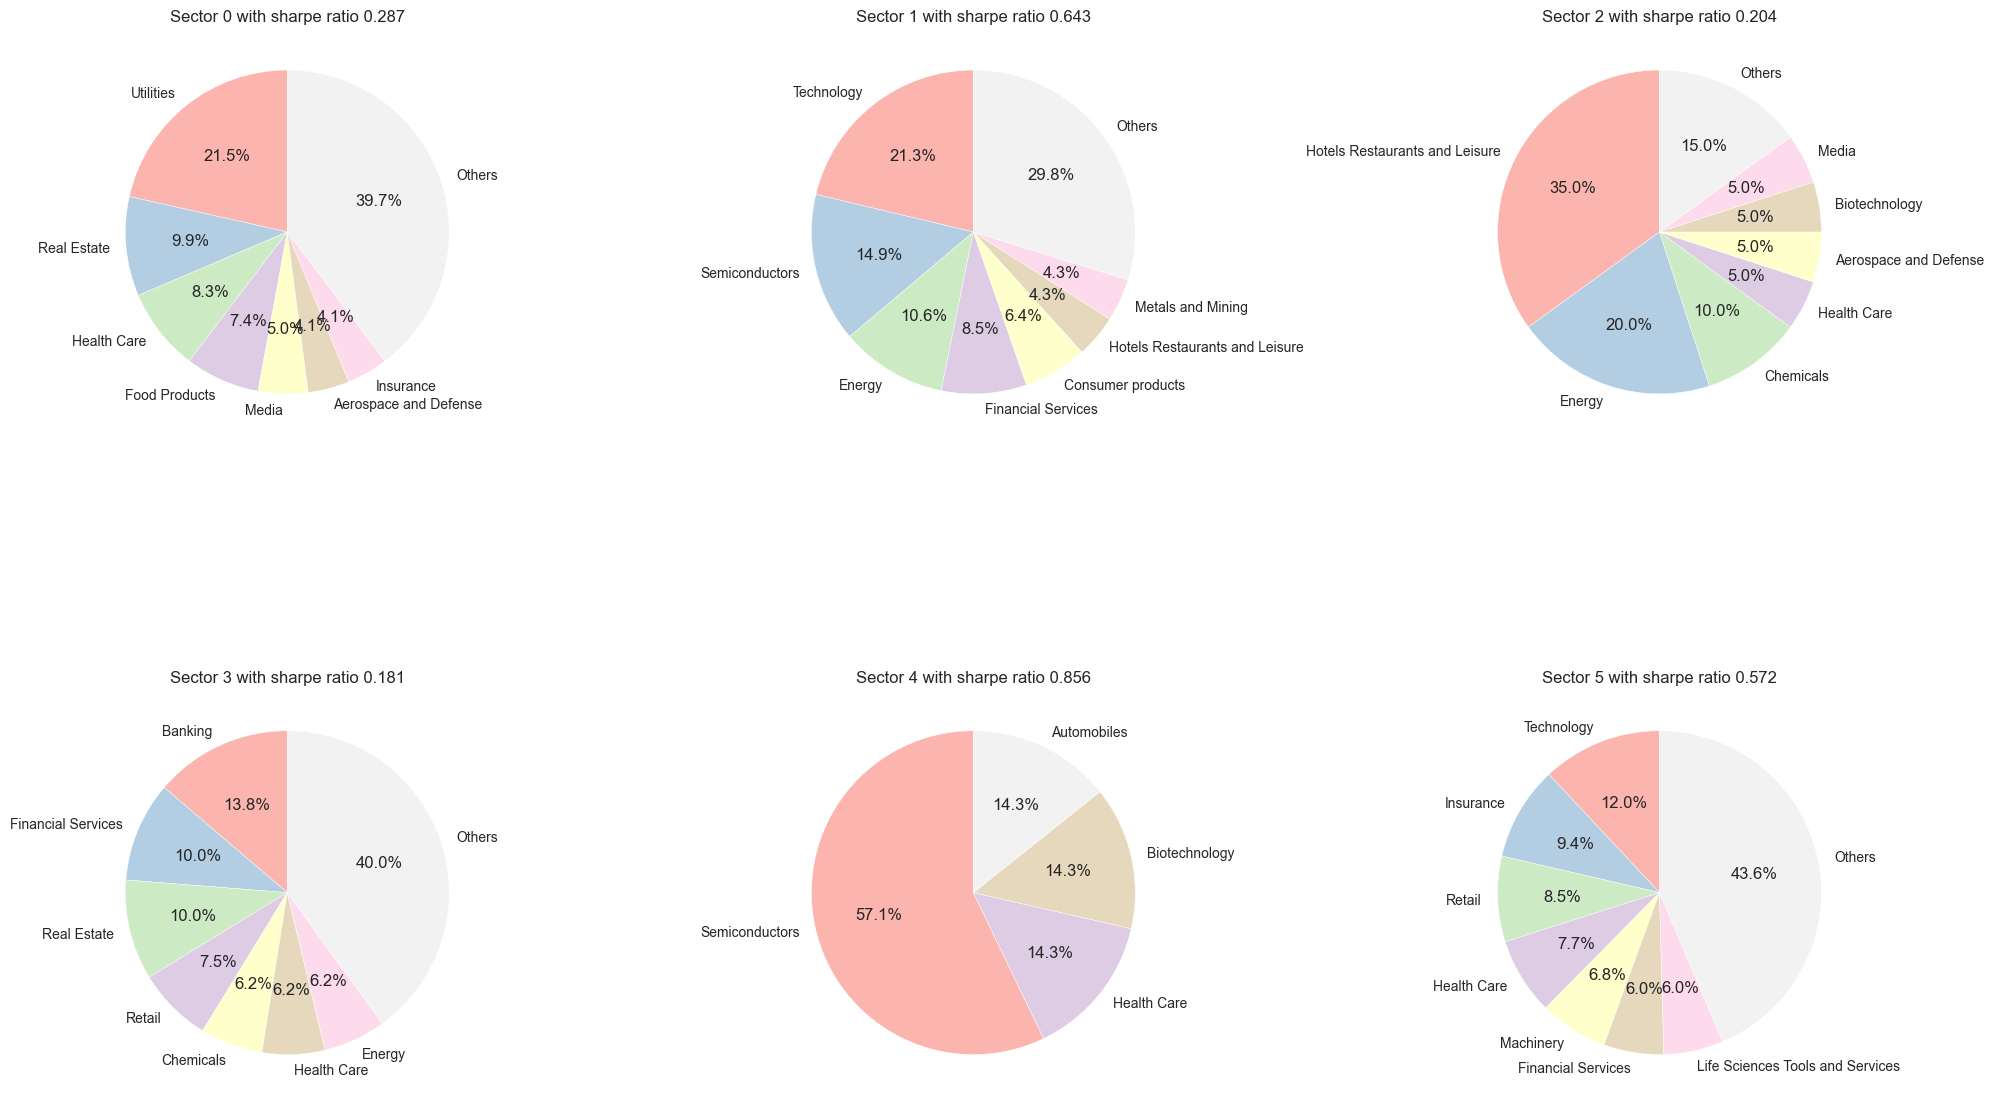

In [26]:
MAX_LABELS = 7
from analysis.data.plotting import plot_cluster_industry
plot_cluster_industry(MAX_LABELS, final_dataframe, cluster_profile)


In [27]:
from analysis.data.dataframe_creation import create_portfolio_clustered
portfolio_ret, asset_ret = create_portfolio_clustered(sd, ed, final_dataframe, list(final_dataframe["Ticker"]), w = "sharpe")


[*********************100%***********************]  484 of 484 completed

1 Failed download:
['DG']: ConnectionError(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')))


Null values: False
Null values: False


In [28]:
benchmark = yf.download(tickers="SPY", start=sd, end=ed, auto_adjust=True)["Close"]

[*********************100%***********************]  1 of 1 completed


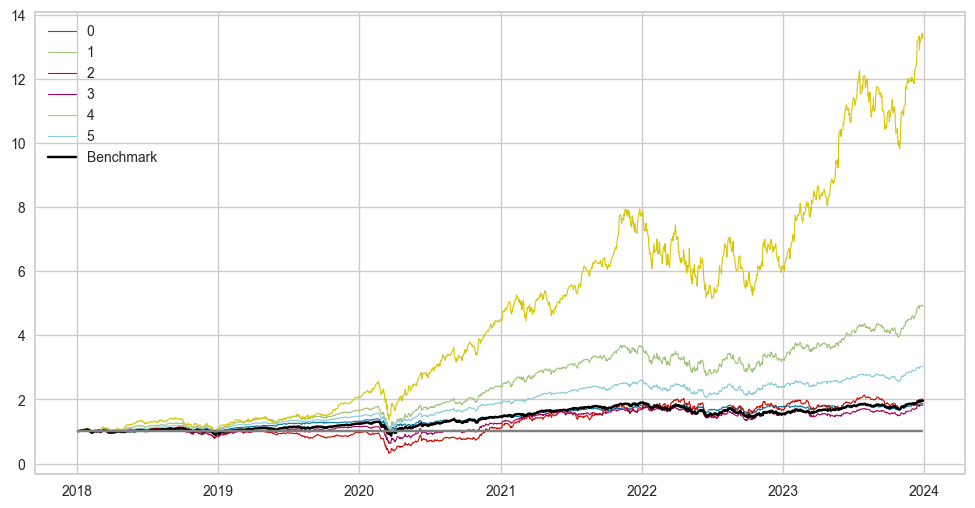

In [29]:
import analysis.data.plotting as plotting
importlib.reload(plotting)
from analysis.data.plotting import portfolio_evolution_time
portfolio_evolution_time(portfolio_ret.reset_index(), benchmark.reset_index())

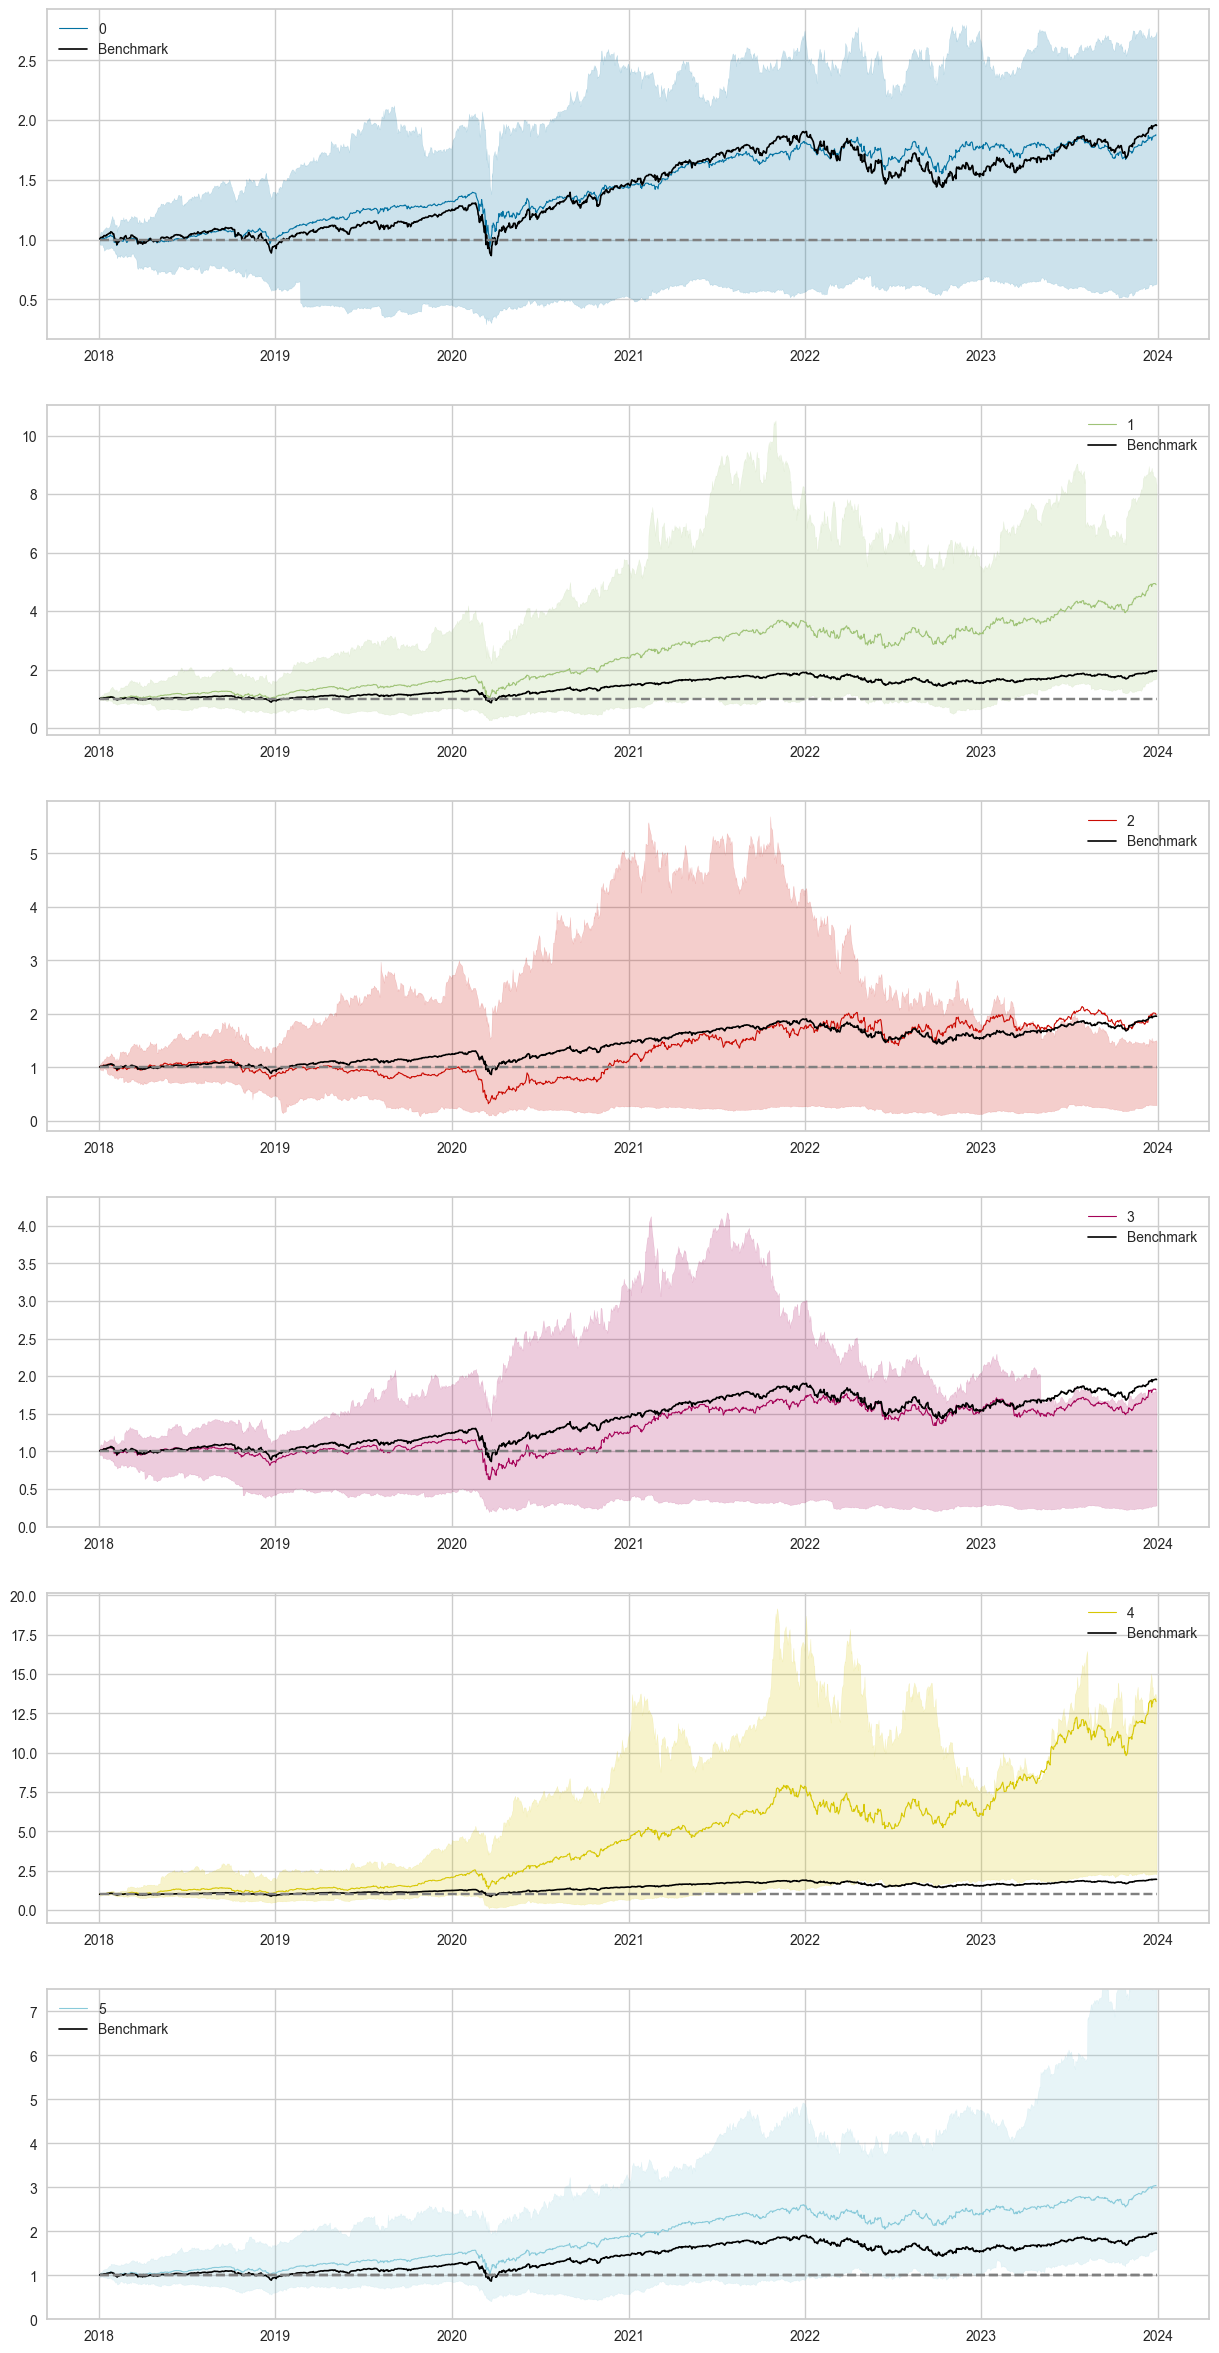

In [30]:
from analysis.data.plotting import portfolio_span
portfolio_span(asset_ret, portfolio_ret, final_dataframe, benchmark, N_SECTORS)

In [31]:
sd_test = ed
ed_test = "2025-01-10"
portfolio_ret_t, asset_ret_t = create_portfolio_clustered(sd_test, ed_test, final_dataframe, list(final_dataframe["Ticker"]), w="sharpe")

[*********************100%***********************]  484 of 484 completed


Null values: False
Null values: False


In [32]:
benchmark_t = yf.download(tickers="SPY", start=sd_test, end=ed_test, auto_adjust=True)["Close"]

[*********************100%***********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2024-01-05   2024-01-05
End Period                 2025-01-08   2025-01-08
Risk-Free Rate             2.0%         2.0%
Time in Market             97.0%        100.0%

Cumulative Return          14.63%       25.98%
CAGR﹪                     9.77%        17.09%

Sharpe                     1.46         1.38
Prob. Sharpe Ratio         91.6%        88.17%
Smart Sharpe               1.44         1.36
Sortino                    2.18         2.07
Smart Sortino              2.16         2.04
Sortino/√2                 1.54         1.46
Smart Sortino/√2           1.52         1.45
Omega                      1.25         1.25

Max Drawdown               -4.53%       -9.83%
Longest DD Days            108          71
Volatility (ann.)          8.14%        16.1%
R^2                        0.34         0.34
Information Ratio          0.05         0.05
Calmar                

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-07-17,2024-08-07,2024-09-25,71,-9.834274,-9.688531
2,2024-04-01,2024-04-19,2024-05-17,47,-7.992516,-7.301246
3,2024-12-03,2025-01-02,2025-01-08,37,-6.948289,-6.906093
4,2024-10-15,2024-10-31,2024-11-07,24,-4.465000,-4.432150
5,2024-11-11,2024-11-15,2024-11-21,11,-3.986728,-2.796633


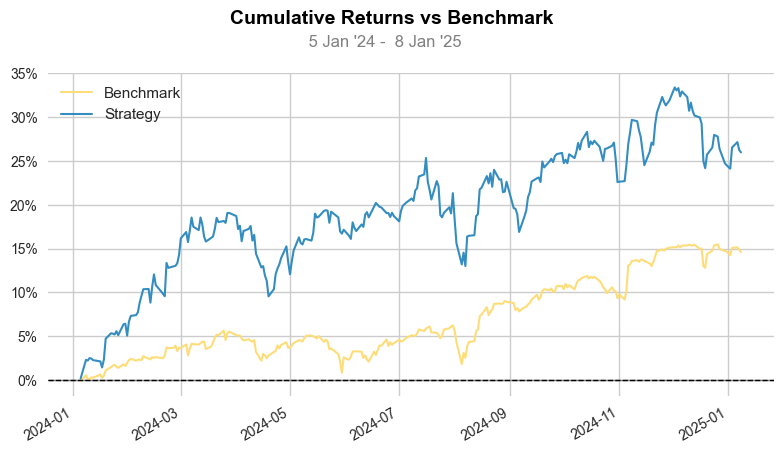

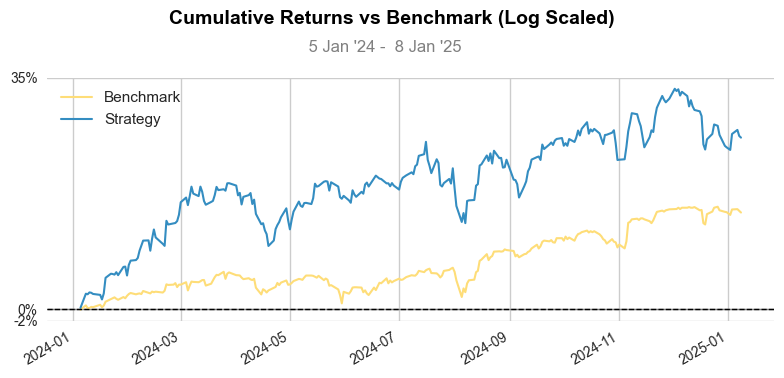

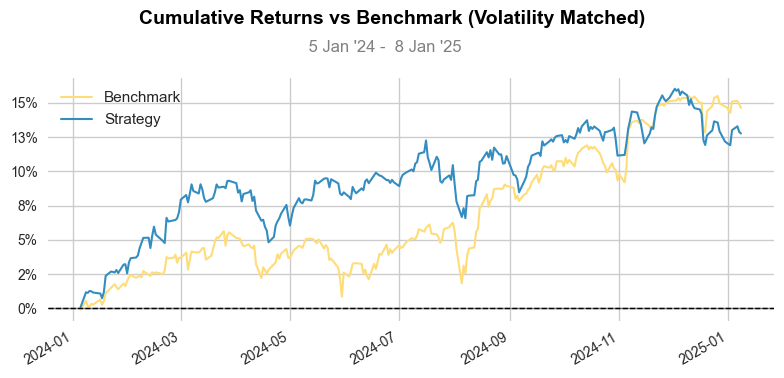

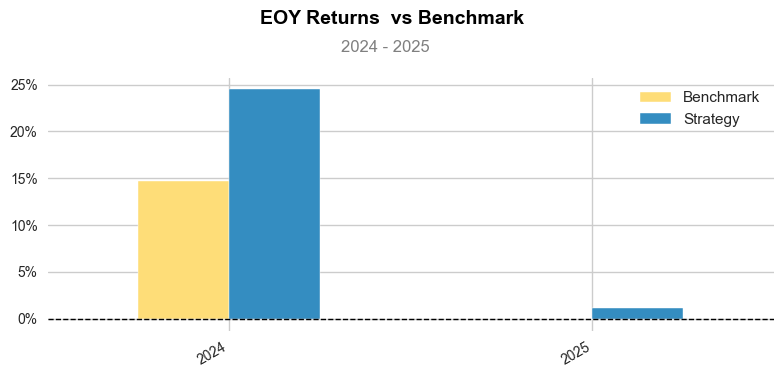

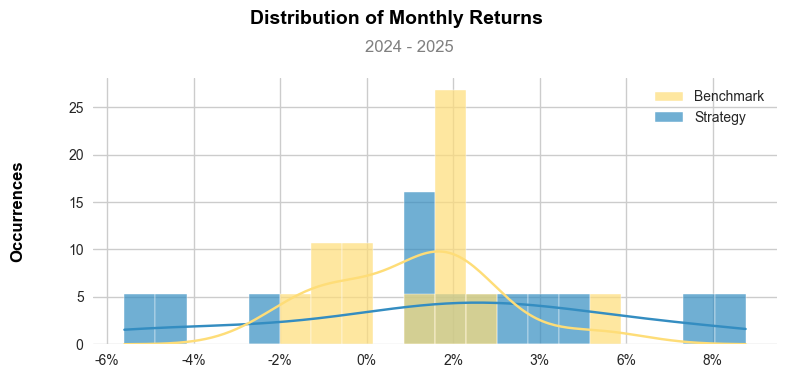

UnsupportedFunctionCall: numpy operations are not valid with resample. Use .resample(...).sum() instead

In [35]:
import quantstats as qs

returns = np.zeros(len(portfolio_ret_t))
cp = cluster_profile.reset_index()
for i in portfolio_ret_t.columns:
        weight = weights(cp[["Sector", "Sharpe_ratio"]], i, 0.33, 0.25).values[0]
        returns += weight*portfolio_ret_t[i] 
portfolio_performance = pd.DataFrame(returns).reset_index()

portfolio_performance["Date"] = pd.to_datetime(portfolio_performance["Date"])

# Set "Date" as the index
portfolio_performance.set_index("Date", inplace=True)

# Rename the column for better clarity (optional)
portfolio_performance.columns = ["Returns"]

# Ensure the returns are properly formatted and call the quantstats report
qs.reports.full(portfolio_performance["Returns"], benchmark='DJIA', rf=0.02)